<a href="https://colab.research.google.com/github/anirudhr20/Brain-Tumor-Detection-Using-Faster-RCNN/blob/master/Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4/tQHRxlSEph_ECHwpbVIq0jLYK5Y1KYMoD7TyN1NbOE_YVTheQtrRj3E

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH_OF_DATA= '/content/gdrive/"My Drive"/data/Tumor'
!ls {PATH_OF_DATA}


detection  test_set  training_set  tumor1.pt  tumor.pt	validation_set


In [0]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
import os
import shutil

In [0]:
data_transforms = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

In [0]:
img_path = '/content/gdrive/"My Drive"/data/Tumor/t'
!ls {img_path}

ls: cannot access '/content/gdrive/My Drive/data/Tumor/t': No such file or directory


In [0]:
IMG_PATH = '/content/gdrive/My Drive/data/Tumor/training_set/'
# split the data by train/val/test

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH +CLASS + '/' + FILE_NAME
            

In [0]:
train_data = datasets.ImageFolder(root='/content/gdrive/My Drive/data/Tumor/training_set', transform=data_transforms)
test_data = datasets.ImageFolder(root='/content/gdrive/My Drive/data/Tumor/test_set', transform=data_transforms)
val_data = datasets.ImageFolder(root='/content/gdrive/My Drive/data/Tumor/validation_set', transform=data_transforms)

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
num_train = len(train_data)
valid_size = 0.2
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


In [0]:
# image_datasets = datasets.ImageFolder(root= "/content/gdrive/My Drive/data/brain/", transform=data_transforms)

# dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=32, shuffle=True, num_workers=2)

num_workers=0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, 
    num_workers=num_workers)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

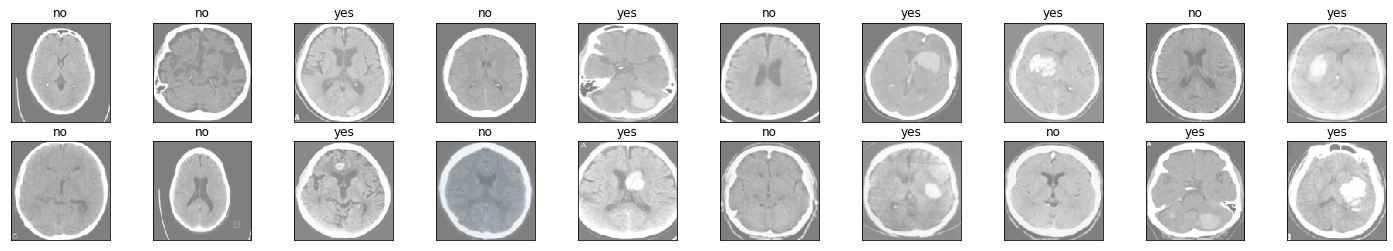

In [0]:
classes = ['no','yes']
dataiter = iter(train_loader)

images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
# CNN architecture
# nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
        #           padding=0, dilation=1, groups=1, bias=True)

import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    
    # sees image as 128*128*3
    self.conv1 = nn.Conv2d(3,20,3,padding=1)
    # sees image as 64*64*20
    self.conv2 = nn.Conv2d(20,10,3,padding=1)
    
    self.pool = nn.MaxPool2d(2, 2)
    # sees image as 32*32*10
    self.fc1 = nn.Linear(32*32*10,500)
    
    self.fc2 = nn.Linear(500,2)
   
  def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten image input
        x = x.view(-1, 32*32*10)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [0]:
model = Model()
print(model)

Model(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10240, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)


In [0]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [0]:
# number of epochs to train the model
n_epochs = 100 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model #
    model.train()
    for data, target in train_loader:
       
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
       
    # validate the model #
   
    # model.eval()
    # for data, target in valid_loader:
    #     # move tensors to GPU if CUDA is available
        
    #     # forward pass: compute predicted outputs by passing inputs to the model
    #     output = model(data)
    #     # calculate the batch loss
    #     loss = criterion(output, target)
    #     # update average validation loss 
    #     valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    # valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))
    
    # save model if validation loss has decreased
    # if valid_loss <= valid_loss_min:
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    #     valid_loss_min,
    #     valid_loss))
    
        # valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 0.422327
Epoch: 2 	Training Loss: 0.416328
Epoch: 3 	Training Loss: 0.410154
Epoch: 4 	Training Loss: 0.413376
Epoch: 5 	Training Loss: 0.405584
Epoch: 6 	Training Loss: 0.415252
Epoch: 7 	Training Loss: 0.399542
Epoch: 8 	Training Loss: 0.405309
Epoch: 9 	Training Loss: 0.399206
Epoch: 10 	Training Loss: 0.405192
Epoch: 11 	Training Loss: 0.402352
Epoch: 12 	Training Loss: 0.380465
Epoch: 13 	Training Loss: 0.383447
Epoch: 14 	Training Loss: 0.377356
Epoch: 15 	Training Loss: 0.379361
Epoch: 16 	Training Loss: 0.395482
Epoch: 17 	Training Loss: 0.380426


KeyboardInterrupt: ignored

In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/data/Tumor/tumor1.pt')

In [0]:
!ls {'/content/gdrive/"My Drive"/data/Tumor/'}

test_set  training_set	tumor1.pt  tumor.pt  validation_set


In [0]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/data/Tumor/tumor.pt'))

<All keys matched successfully>

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
batch_size = 10

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.701675

Test Accuracy of    no: 30% ( 3/10)
Test Accuracy of   yes: N/A (no training examples)

Test Accuracy (Overall): 30% ( 3/10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


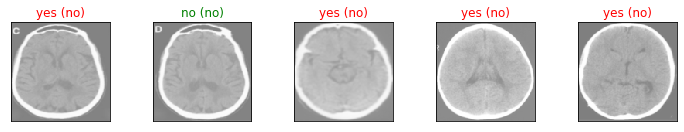

In [0]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available


# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [0]:
import torchvision.models as models

In [0]:
smodel = models.detection.fasterrcnn_resnet50_fpn(pretrained=True,progress=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 54.3MB/s]


In [0]:
smodel.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

In [0]:
maskmodel = models.detection.maskrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:04<00:00, 42.7MB/s]


In [0]:

dataiter = iter(test_loader)
images, labels = dataiter.next()



In [0]:
pre = maskmodel([images[0]])
print(pre)

ValueError: ignored

In [0]:
predictions = smodel([images[1]])

In [0]:
print(predictions)

[{'boxes': tensor([[  6.1660,   7.8013, 116.9060, 118.2527],
        [  2.2184,   1.5873, 123.7673, 128.0000],
        [  1.3931,   5.7404, 128.0000, 124.9542],
        [  2.4083,   9.3763, 125.7716, 124.1137],
        [  2.9068,  16.3011, 126.1110, 124.9556],
        [  1.7653,   7.0346, 127.8685, 122.6729],
        [  0.0000,   0.0000, 128.0000, 128.0000]], grad_fn=<StackBackward>), 'labels': tensor([17, 24, 47, 51, 34, 86,  3]), 'scores': tensor([0.6669, 0.5651, 0.1481, 0.1477, 0.0856, 0.0834, 0.0512],
       grad_fn=<IndexBackward>)}]


In [0]:
# threshold = 0.585
# predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions[0]['boxes'].detach().numpy())] # Bounding boxes
# predictions_score = list(predictions[0]['scores'].detach().numpy())
# predictions_t=0
# for x in predictions_score:
#   if x > threshold:
#     predictions_t = predictions_score.index(x) 
# # predictions_t = predictions_ti # Get list of index with score greater than threshold.
# predictions_boxes = predictions_boxes[:predictions_t+1]
# print(predictions_boxes)

[[(1.0738428, 1.3042529), (125.10324, 127.10531)]]


In [0]:
d_transforms = transforms.Resize((128,128))
img = d_transforms(images[0])


TypeError: ignored

In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('trans.py','wb').write(src)


Saving trans.py to trans (1).py


1518

In [0]:
from PIL import *
# import trans as T
# categories = ['1','2','3','4','5','6','7']
import cv2

In [0]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  # transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  # img = transform(img) # Apply the transform to the image
  data_transforms = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
  img = data_transforms(img)
  pred = smodel([img]) # Pass the image to the model
  # for i in list(pred[0]['labels'].numpy()):
  #   pred_class = [categories[i]] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t=0
  for x in pred_score:
    if x > threshold:
      pred_t = pred_score.index(x) 
  # pred_t = pred_ti # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  # pred_class = pred_class[:pred_t+1]
  return pred_boxes

In [0]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
 
  boxes = get_prediction(img_path, threshold) # Get predictions
  img1 = cv2.imread(img_path) # Read image with cv2
  
  img = cv2.resize(img1,(128,128))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    # cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(20,3)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

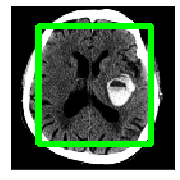

In [0]:
object_detection_api('/content/gdrive/My Drive/data/Tumor/test_set/Yes/002.png', threshold=0.8)

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [0]:
fmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = fmodel.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
fmodel.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [0]:
print(fmodel)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

In [0]:

params = [p for p in fmodel.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 6019 (delta 7), reused 8 (delta 2), pack-reused 5994
Receiving objects: 100% (6019/6019), 9.59 MiB | 8.48 MiB/s, done.
Resolving deltas: 100% (3993/3993), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
device = torch.device('cpu')
fmodel.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

In [0]:

params = [p for p in fmodel.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:

t_data = datasets.ImageFolder(root='/content/gdrive/My Drive/data/Tumor/detection/Train/', transform=get_transform(train=True))

In [0]:
t_loader = torch.utils.data.DataLoader(
    t_data, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
test_d = datasets.ImageFolder(root='/content/gdrive/My Drive/data/Tumor/detection/Test/', transform=get_transform(train=True))

In [0]:
tes_loader = torch.utils.data.DataLoader(
    test_d, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
# let's train it for 10 epochs
device = torch.device('cpu')
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(fmodel, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(fmodel, test_loader, device=device)

AttributeError: ignored